In [498]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.markers as mks
import numpy as np
import pprint
import random as rn
from itertools import chain
import math

In [499]:
# Parameters for standard configuration
NT = 400  # total number of TDR facilities available
ST = 0.975 # safety level threshold
M = 10**6  # total demands threshold
L = 1000  # Lambda: scaling factor for total number of facilities opened
A = 10  # Alpha: maximum number of neighborhoods that a neighborhood can serve
B = 10  # Beta: maximum number of neighborhoods that a neighborhood can be served by
G = 15  # Gamma: penalty for unit unmet demand
k = ["Water", "Food", "Medical Kit"]  # commodities type
v = dict(zip(k, [1, 1, 0.5]))  # unit volume of commodity k
w = dict(zip(k, [1, 0.25, 0.25]))  # unit weight of commodity k
cd = dict(zip(k, [2.5, 3, 0.333]))  # commodities demand of an injured in 1day
V = 34560*5 # Volume Capacity of TDR
W = 30480 # Weight Capacity of TDR

In [500]:
# Reading the File
n = [] # maximum number of TDR facilities that can be allocated in neighborhood i
s = [] # safety level of neighborhood i
elite_Chromosoms = []
elites_fitness = math.inf
x_nodes = []
y_nodes = []
No_nodes = 0
No_supplierNodes = 0
No_demandNodes = 0
supplier_nodes_index = []
demand_nodes_index = []
v_capacity = []
w_capacity = []
v_demands = []
w_demands = []
dist = [] # distance between neighborhoods i and j
def readfile(path: str):
    global No_nodes, No_supplierNodes, No_demandNodes, supplier_nodes_index, demand_nodes_index, n, v_demands
    with open(path, "r") as file:
        lines = file.readlines()
    # print(lines)
    for i, line in enumerate(lines, start=1):
        if 2 < i:
            NodesAttributes = line.split(",")
            x_nodes.append(float(NodesAttributes[7]))
            y_nodes.append(float(NodesAttributes[8]))
            population = int(NodesAttributes[4])
            No_facility = int(NodesAttributes[6])
            n.append(No_facility)
            s.append(float(NodesAttributes[5]))
            v_capacity.append(V*(No_facility))
            w_capacity.append(W*No_facility)
            v_demands.append(sum([x * y * population for x, y in zip(list(v.values()), list(cd.values()))]))
            w_demands.append(sum([x * y * population for x, y in zip(list(w.values()), list(cd.values()))]))
    print("x_nodes = ", x_nodes, "\ny_nodes = ", y_nodes, "\nv_capacity = ",
        v_capacity, "\nw_capacity = ", w_capacity, "\nv_demands = ",
        v_demands, "\nw_demands =", w_demands, "\nSafty Levels = ", s)
    
    print("\nSumVolumeCapacities = ", sum(v_capacity), "\nSumWeightCapacities = ", sum(w_capacity),
          "\nSumVolumeDemands = ", sum(v_demands), "\nSumWeightDemands = ", sum(w_demands))

    No_nodes = len(x_nodes)
    supplier_nodes_index = [index for index, s in enumerate(s) if s >= ST]
    demand_nodes_index = [index for index, s in enumerate(s) if s < ST]
    No_supplierNodes = len(supplier_nodes_index)
    No_demandNodes = len(demand_nodes_index)
    print("\nNum of Nodes = ",No_nodes,
          "\nNum of Spplier Nodes = ", No_supplierNodes,
          "\nNum of demand Nodes = ", No_demandNodes,
          "\nSupplier Nodes Index = ", supplier_nodes_index,
          "\nDemand Nodes Index = ", demand_nodes_index)
    

readfile("C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\Neighborhood_Data.txt")    

x_nodes =  [542854.6354575139, 544297.7334397715, 544944.215181266, 545825.418826526, 541240.2444018908, 539921.3650180083, 540175.8892363384, 540605.2459170669, 539128.6217184188, 537574.0052861953, 541602.5902471552, 542304.9197994834, 542259.151118977, 541522.5829327758, 546184.1424427144, 544978.7931347527, 545663.0204727789, 547881.51214989, 538914.6155979317, 534686.893008735, 543518.8594746208, 547080.3030648893, 541319.7851449214, 543220.0095095076, 542405.1251548771, 544162.6504610088, 550893.5400929973, 546508.6861207737, 548245.1148169972, 549254.8346710587, 548105.9195804857, 545616.740718483, 546071.1267206725, 543305.90639506, 545292.4495104905, 545082.5480190925, 549457.8557848195, 550944.8534072414, 552475.7698982758, 549675.2819713792, 547310.3965815576, 536145.5420112209, 535431.0558279892, 537240.8895195238, 539381.1751644257, 546648.7023844942, 539127.8325918401, 538275.1273844559, 537466.9793481054, 542635.9756636173, 540088.92828108, 541162.2788729379, 535553.4739

In [501]:
def DistMatrix():
    distmatrix = np.empty((No_nodes, No_nodes), dtype=float)
    for i in range(No_nodes):
        for j in range(No_nodes):
            distmatrix[i][j] = round(math.sqrt( pow(x_nodes[i]-x_nodes[j],2) + pow(y_nodes[i]-y_nodes[j],2)), 2)
    return distmatrix
distmatrix = DistMatrix()
pprint.pprint(distmatrix)

array([[    0.  ,  1517.52,  2162.  , ...,  9381.41,  8914.95, 10377.78],
       [ 1517.52,     0.  ,   652.11, ..., 10371.91, 10216.28, 11687.02],
       [ 2162.  ,   652.11,     0.  , ..., 10745.77, 10729.68, 12201.25],
       ...,
       [ 9381.41, 10371.91, 10745.77, ...,     0.  ,  3100.57,  3609.36],
       [ 8914.95, 10216.28, 10729.68, ...,  3100.57,     0.  ,  1471.57],
       [10377.78, 11687.02, 12201.25, ...,  3609.36,  1471.57,     0.  ]])


In [502]:
# Initial Population
Population = []
def generate_initial_population(pop_size):
    for ـ in range(pop_size):
        Chromosom = []
        selectable = demand_nodes_index.copy()
        for i in range(No_nodes):
            if (i <= len(demand_nodes_index)-1):
                j = rn.choice(selectable)
                selectable.remove(j)
            else:
                j = rn.choice(range(min(n),n[supplier_nodes_index[i-len(demand_nodes_index)]]+1))
            Chromosom.append(j)

        Population.append(Chromosom)
    return Population
Population = generate_initial_population(300)
# print(Population)

In [503]:

# Fitness
def distance(pop: list):
    distance_fitness = []
    d_supp = np.array([v_demands[s] for s in supplier_nodes_index])
    c_supp = np.array([i*V  for i in pop[No_demandNodes:]])- d_supp
    d = np.array([v_demands[i] for i in demand_nodes_index])
    j = 0
    end = False
    for i in range(No_supplierNodes):
        while c_supp[i] >= d[j]:
            distance_fitness.append(distmatrix[supplier_nodes_index[i], pop[j]])
            c_supp[i] -= d[j]
            d[j] = 0
            j += 1
            if j == No_demandNodes:
                end = True
                break
        if end == True:
            break
        d[j] -= c_supp[i]
        c_supp[i] = 0
    return sum(distance_fitness)
def fitness(population: list):
    global elite_Chromosoms, elites_fitness
    Fitness = []
    for pop in population:
        
        sum_facilities_fitness = sum(pop[No_demandNodes: len(pop)])
        
        d = sum(v_demands)
        c = sum([V*i for i in pop[No_demandNodes:]])
        if d-c > 0:
            unmet_demand_fitness = (d-c)
        else:
            unmet_demand_fitness = abs((d-c))
        
        distance_fitness = distance(pop)

            
        Fitness.append(sum_facilities_fitness*L + unmet_demand_fitness*G + distance_fitness)
    if min(Fitness) < elites_fitness:
        elites_fitness = min(Fitness)
        elite_Chromosoms = Population[Fitness.index(min(Fitness))]
    return Fitness
# Fitness = fitness(Population)
# print(Fitness)

In [504]:
# SRS Selection
Ranking = range(1,len(Population)+1)
K = len(Ranking)
ChromosomsProb =[]
ProbsRange = []
for i in Ranking:
    if i <= K/2:
        ChromosomsProb.append((12*i)/(5*K*(K+2)))
    else:
        ChromosomsProb.append((28*i)/(5*K*(3*K+2)))
for index, i in enumerate(ChromosomsProb):
    if index == 0:
        ProbsRange.append([0,i])
    else:
        ProbsRange.append([ProbsRange[index-1][1], ProbsRange[index-1][1] + (i)])
def SRS_Selection(ChromosomsFitness: list):
    selectedchromosomforcrossover = []
    SelectedChromosomForCrossOver = []
    if elites_fitness not in ChromosomsFitness: 
        Population[rn.randint(0,len(Population)-1)] = elite_Chromosoms
    ChromosomsFitnessSorted = sorted(ChromosomsFitness, reverse=True)
    ChromosomsIndexByFitness = [ChromosomsFitness.index(i) for i in ChromosomsFitnessSorted]
    for _ in Ranking:
        r = rn.uniform(0,1)
        for index, j in enumerate(ProbsRange):
            if r > j[0] and r <= j[1]:
                selectedchromosomforcrossover.append(ChromosomsIndexByFitness[index])
                if len(selectedchromosomforcrossover) == 2:
                    SelectedChromosomForCrossOver.append(selectedchromosomforcrossover)
                    selectedchromosomforcrossover = []
                    break
    # print(f"SelectedChromosomForCrossOver length = {len(SelectedChromosomForCrossOver)}")
    return SelectedChromosomForCrossOver
# selectedChromosom = SRS_Selection(Fitness)
# print(selectedChromosom)

In [505]:
# OX Crossover
def OX_Crossover(selectedcrossover):
    childs = []
    for i in selectedcrossover:
        r = rn.uniform(0,1)
        if r < 0.8:
            p1 = Population[i[0]]
            p2 = Population[i[1]]
            child1 = [1]*len(p1)
            child2 = [1]*len(p1)
            crossoverindex = rn.sample(list(range(len(demand_nodes_index))),2)
            bp1 = p1[min(crossoverindex):max(crossoverindex)+1]
            bp2 = p2[min(crossoverindex):max(crossoverindex)+1]
            child1[min(crossoverindex):max(crossoverindex)+1] = bp2.copy()
            child2[min(crossoverindex):max(crossoverindex)+1] = bp1.copy()
            Chain = chain(range(min(crossoverindex)), range(max(crossoverindex)+1, len(child1)))
            for j in Chain:
                chekpoint1 = p1[j]
                chekpoint2 = p2[j]
                m = 0
                ch = False
                while chekpoint1 in bp2:
                    m += 1
                    chekpoint1 = bp1[bp2.index(chekpoint1)]
                    if m > len(bp2):
                        ch = True
                        child1[j] = p2[j]
                        break
                if ch == False:
                    child1[j] = chekpoint1
                m = 0
                ch = False
                while chekpoint2 in bp1:
                    m += 1
                    chekpoint2 = bp2[bp1.index(chekpoint2)]
                    if m > len(bp1):
                        ch = True
                        child2[j] = p1[j]
                        break
                if ch == False:
                    child2[j] = chekpoint2
                
                
            for index, i in enumerate(p2[len(demand_nodes_index):]):
                child1[len(demand_nodes_index)+index] = i
                child2[len(demand_nodes_index)+index] = p1[len(demand_nodes_index)+index]
                
            childs.append(child1)
            childs.append(child2)
            
        else:
            childs.append(Population[i[0]])
            childs.append(Population[i[1]])
    return childs
# def OX_Crossover(selectedcrossover):
#     childs = []
#     for sc in selectedcrossover:
#         parent1 = Population[sc[0]]
#         parent2 = Population[sc[1]]
#         if rn.uniform(0,1) <= 0.9:
#             crossover_point = rn.randint(1, len(demand_nodes_index))
#             child1p1 = parent1[:crossover_point] + parent2[crossover_point:len(demand_nodes_index)]
#             child2p1 = parent2[:crossover_point] + parent1[crossover_point:len(demand_nodes_index)]
#             child1p2 = []
#             child2p2 = []
#             for index, i in enumerate(parent2[len(demand_nodes_index):]):
#                 if i <= n[len(demand_nodes_index)+index]:
#                     child1p2.append(i)
#                     child2p2.append(parent1[len(demand_nodes_index)+index])
#                 else: 
#                     child1p2.append(parent1[len(demand_nodes_index)+index])
#                     child2p2.append(i)
#             child1 = child1p1 + child1p2
#             child2 = child2p1 + child2p2
                
#             childs.append(child1)
#             childs.append(child2)
#         else:
#             childs.append(parent1)
#             childs.append(parent2)
#     return childs
# childs = OX_Crossover(selectedChromosom)
# print(childs)

In [506]:
# Mutation
def Mutation(childs: list):
    childsaftermutation = []
    for i in childs:
        r = rn.uniform(0,1)
        if r <= 0.2:
            rnd = rn.sample(list(range(len(demand_nodes_index))),2)
            rnd0 = i[rnd[0]]
            rnd1 = i[rnd[1]]
            i[rnd[0]] = rnd1
            i[rnd[1]] = rnd0
            childsaftermutation.append(i)
            
            # rnd = rn.sample(list(range(len(demand_nodes_index), len(i))),2)
            # rnd0 = i[rnd[0]]
            # rnd1 = i[rnd[1]]
            # if n[rnd[1]] > rnd0 and n[rnd[0]] > rnd1:
            #     i[rnd[0]] = rnd1
            #     i[rnd[1]] = rnd0
            # childsaftermutation.append(i)
        else:
            childsaftermutation.append(i)
    return childsaftermutation
# mutation = Mutation(childs)
# print(mutation)

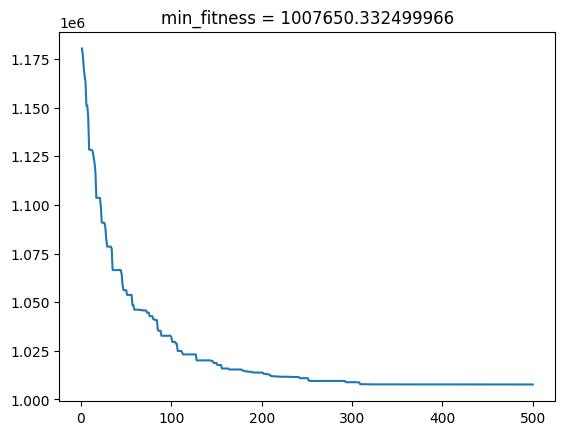

Best Solution =  [9, 4, 8, 50, 18, 6, 47, 5, 27, 45, 40, 17, 1, 20, 23, 2, 7, 25, 24, 0, 21, 30, 26, 39, 29, 3, 35, 32, 37, 41, 46, 43, 51, 59, 61, 11, 53, 33, 12, 56, 54, 55, 15, 13, 16, 48, 19, 63, 62, 52, 11, 3, 8, 7, 4, 4, 2, 2, 3, 4, 3, 5, 3, 4]

SumDemand =  10832268.394500002 
SumSupply =  10886400

Total Facilities opened =  63 
Unmet Demand =  -54131.605499997735 
Total Distance =  132676.25


In [507]:
# Generation
def Generation(repeat):
    global Population
    g = range(1,repeat+1)
    minfit = []
    for i in range(repeat):
        Fitness = fitness(Population)
        minfit.append(min(Fitness) if (min(Fitness) <= elites_fitness) else elites_fitness)
        SelectedChromosoms = SRS_Selection(Fitness)
        Childs = OX_Crossover(SelectedChromosoms)
        childsaftermutation = Mutation(Childs)
        Population = childsaftermutation
    # Chromosom_Plot(InitialChromosoms[Fitness(InitialChromosoms).index(min(Fitness(InitialChromosoms)))])
    best_solution = Population[fitness(Population).index(min(fitness(Population)))]
    plt.plot(g,minfit)
    plt.title(f'min_fitness = {minfit[-1]}')
    # plt.figure(1)
    plt.show()
    return best_solution
best_solution = Generation(500)
print("Best Solution = ",best_solution)
print("\nSumDemand = ", sum(v_demands), "\nSumSupply = ", sum(V*n for n in best_solution[No_demandNodes:]))
print("\nTotal Facilities opened = ",sum(best_solution[No_demandNodes:]),
      "\nUnmet Demand = ", sum(v_demands)-sum(V*n for n in best_solution[No_demandNodes:]),
      "\nTotal Distance = ",distance(best_solution))

c_supp = [1579526.4495  374686.227  1215255.2495 1072822.023   522428.964
  545440.6205  307742.1135   52653.283   409926.1905  552308.4185
  390484.429   771024.068   432065.206   462080.739 ] 
 d = [300766.487  186767.84   208895.5225 172187.9355 183339.6075 103566.6205
 130119.8395  97418.468  225685.362  151550.5425 109510.779   75749.772
  47445.6045  17271.492  136772.3105 129360.5285  82526.906   38073.2135
 227419.311  321647.5395 385338.9995 171286.962  122413.3995 228563.944
 282554.356  184552.2385 706238.561  265645.52   355703.2045 254182.1905
 324758.448  333008.872  123456.0355 119047.4985 116877.229  182381.969
 173723.557   99611.4035 172131.2705 139849.22   107635.1675  46612.629
  86006.137   55480.7015 171218.964   80600.296   63929.453  135117.6925
  49655.5395 150655.2355] 

c_supp = [1278759.9625  374686.227  1215255.2495 1072822.023   522428.964
  545440.6205  307742.1135   52653.283   409926.1905  552308.4185
  390484.429   771024.068   432065.206   462080.739 

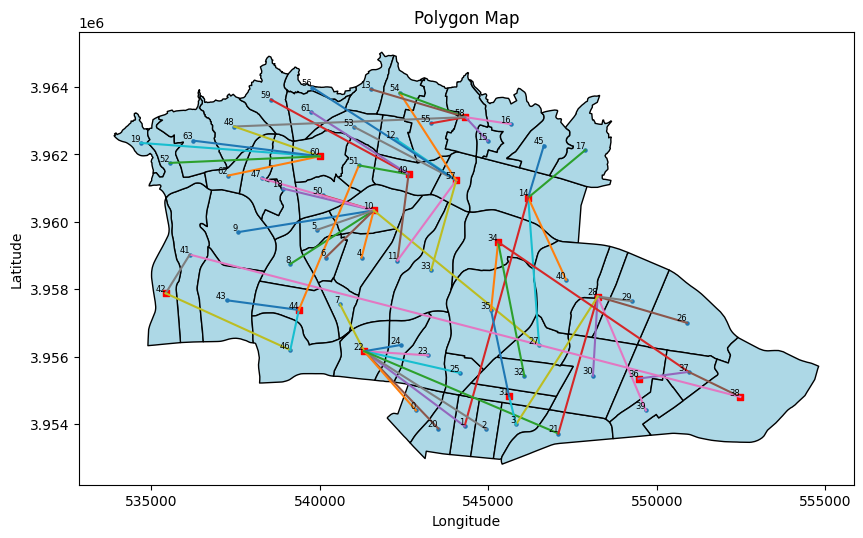

In [508]:
def chromosomplot(bestsolution):
    
# display shp file
    shapefile_path = "C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\Mahallat\\Reg1_3_4.shp"
    polygons = gpd.read_file(shapefile_path)
    # print(polygons.head())
    polygons.plot(edgecolor='black', facecolor='lightblue', figsize=(10, 8))
    plt.title("Polygon Map")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

# display nodes
    x_d = []
    y_d = []
    x_s = []
    y_s = []
    for i in demand_nodes_index:
        x_d.append(x_nodes[i])
        y_d.append(y_nodes[i])
    plt.scatter(x_d, y_d, s=5)
    for i in supplier_nodes_index:
        x_s.append(x_nodes[i])
        y_s.append(y_nodes[i])
    plt.scatter(x_s, y_s, c='r', s=15, marker='s')
    
    for n, txt in enumerate(range(No_nodes)):
        plt.text(x_nodes[n], y_nodes[n], n, fontsize=6, ha='right', va='bottom')
    
# display allocating nodes
    d_supp = np.array([v_demands[s] for s in supplier_nodes_index])
    c_supp = np.array([i*V  for i in best_solution[No_demandNodes:]]) - d_supp
    d = np.array([v_demands[i] for i in demand_nodes_index])
    j = 0
    end = False
    for i in range(No_supplierNodes):
        x = []
        y = []
        print(f"c_supp = {c_supp} \n d = {d} \n")
        while c_supp[i] >= d[j]:
            c_supp[i] -= d[j]
            d[j] = 0
            print(f"c_supp = {c_supp} \n d = {d} \n")
            x.append(x_nodes[supplier_nodes_index[i]])
            y.append(y_nodes[supplier_nodes_index[i]])
            x.append(x_nodes[bestsolution[j]])
            y.append(y_nodes[bestsolution[j]])
            plt.plot(x,y)
            x= []
            y = []
            j += 1
            if j == No_demandNodes:
                end = True
                break
        if end == True:
            break
        d[j] -= c_supp[i]
        c_supp[i] = 0
        print(f"c_supp = {c_supp} \n d = {d} \n")
        x.append(x_nodes[supplier_nodes_index[i]])
        y.append(y_nodes[supplier_nodes_index[i]])
        x.append(x_nodes[bestsolution[j]])
        y.append(y_nodes[bestsolution[j]])
        plt.plot(x,y)
    plt.figure(1)
    plt.show()
chromosomplot(best_solution)    